## https://docs.oceanparcels.org/en/latest/examples/tutorial_croco_3D.html
## https://virtualfleet.readthedocs.io/en/latest/

In [1]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import timedelta
import xarray as xr
from glob import glob
import sys, os
import cartopy
cartopy.config['pre_existing_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['repo_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
import parcels
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])
pr1=ccrs.PlateCarree()

sys.path.insert(0, os.path.abspath(os.path.join(".")))
from virtualargofleet import Velocity, VirtualFleet, FloatConfiguration, VelocityField
#U1000=np.load('u1000.npy')
#V1000=np.load('v1000.npy')

In [8]:
ds=xr.open_dataset('CROCO_idealized.nc')
ds

<xarray.Dataset> Size: 1MB
Dimensions:     (xi_rho: 62, xi_u: 61, eta_rho: 52, eta_v: 51, s_rho: 10,
                 s_w: 11, time: 1, auxil: 4)
Coordinates:
  * xi_rho      (xi_rho) float32 248B 1.0 2.0 3.0 4.0 ... 59.0 60.0 61.0 62.0
  * xi_u        (xi_u) float32 244B 1.5 2.5 3.5 4.5 5.5 ... 58.5 59.5 60.5 61.5
  * eta_rho     (eta_rho) float32 208B 1.0 2.0 3.0 4.0 ... 49.0 50.0 51.0 52.0
  * eta_v       (eta_v) float32 204B 1.5 2.5 3.5 4.5 5.5 ... 48.5 49.5 50.5 51.5
  * s_rho       (s_rho) float32 40B -0.95 -0.85 -0.75 ... -0.25 -0.15 -0.05
  * s_w         (s_w) float32 44B -1.0 -0.9 -0.8 -0.7 ... -0.3 -0.2 -0.1 0.0
    x_rho       (eta_rho, xi_rho) float32 13kB ...
    y_rho       (eta_rho, xi_rho) float32 13kB ...
  * time        (time) float64 8B 1.92e+04
Dimensions without coordinates: auxil
Data variables: (12/25)
    spherical   |S1 1B ...
    xl          float32 4B ...
    el          float32 4B ...
    Vtransform  float32 4B ...
    sc_r        (s_rho) float32 40B ...
    sc_w        (s_w) float32 44B ...
    ...          ...
    v           (time, s_rho, eta_v, xi_rho) float32 126kB ...
    temp        (time, s_rho, eta_rho, xi_rho) float32 129kB ...
    rho         (time, s_rho, eta_rho, xi_rho) float32 129kB ...
    omega       (time, s_w, eta_rho, xi_rho) float32 142kB ...
    w           (time, s_rho, eta_rho, xi_rho) float32 129kB ...
    AKt         (time, s_w, eta_rho, xi_rho) float32 142kB ...
Attributes: (12/69)
    type:           CROCO history file
    title:          \tIdealized
    date:           
    rst_file:       idealized_rst.nc
    his_file:       idealized_his.nc
    theta_s:        1.0
    ...             ...
    levbfrc:        1
    levbfrc_expl:   Deepest level for body-force stress
    gamma2:         1.0
    gamma2_expl:    Slipperiness parameter
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    IDEALIZED OBC_EAST OBC_WEST OBC_NORTH OBC_SOUTH SOLVE3D U...

In [4]:
variables = {"U": "u", "V": "v", "W": "w", "H": "h"}

lon_rho = "x_rho"  # Note, this would be "lon_rho" for a dataset on a spherical grid
lat_rho = "y_rho"  # Note ,this would be "lat_rho" for a dataset on a spherical grid

dimensions = {
    "U": {"lon": lon_rho, "lat": lat_rho, "depth": "s_w", "time": "time"},
    "V": {"lon": lon_rho, "lat": lat_rho, "depth": "s_w", "time": "time"},
    "W": {"lon": lon_rho, "lat": lat_rho, "depth": "s_w", "time": "time"},
    "H": {"lon": lon_rho, "lat": lat_rho},
}
fieldset = parcels.FieldSet.from_croco(
    'CROCO_idealized.nc',
    variables,
    dimensions,
    allow_time_extrapolation=True,  # Note, this is only needed for this specific example dataset, that has only one snapshot
    mesh="flat",  # Note, this is only needed for this specific example dataset, that has been created on a 'flat' mesh (i.e. in km instead of in degrees)
)

/dev/shm/pbs.1135685.datarmor0/ipykernel_35489/1297568742.py:12: FieldSetWarning: Note that it is unclear which vertical velocity ('w' or 'omega') to use in 3D CROCO fields.
See https://docs.oceanparcels.org/en/latest/examples/tutorial_croco_3D.html for more information
  fieldset = parcels.FieldSet.from_croco(


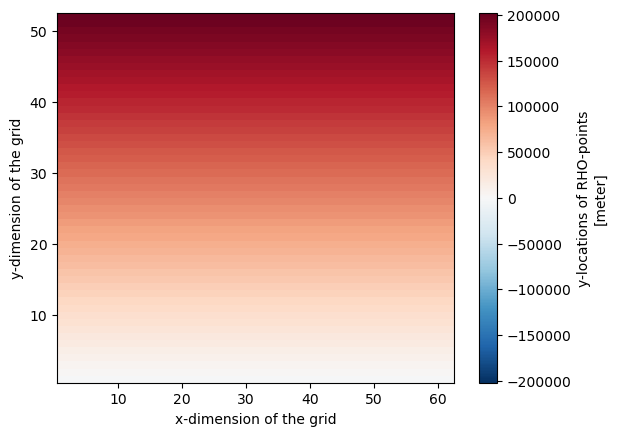

In [12]:
ds.y_rho.plot()

In [33]:
fieldset.U.grid.depth

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1],
      dtype=float32)

In [47]:
x = 100e3
y = 100e3
t = 0
z = -1000 / fieldset.H[0,0,100e3,100e3]
print(t,z,y,x)

0 -0.6635700066357001 100000.0 100000.0


In [48]:
fieldset.UVW[t,z,y,x]

(1.0, 0.0, -0.026251401752233505)

In [16]:
X, Z = np.meshgrid(
    [40e3, 80e3, 120e3],
    [100, -10, -130, -250, -400, -850, -1400, -1550],
)
Y = np.ones(X.size) * fieldset.U.grid.lat[25]


def DeleteParticle(particle, fieldset, time):
    if particle.state >= 50:
        particle.delete()


pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=parcels.JITParticle, lon=X, lat=Y, depth=Z
)

outputfile = pset.ParticleFile(name="/home1/datawork/kbalem/croco_particles3D.zarr", outputdt=5000)

pset.execute(
    [parcels.AdvectionRK4_3D, DeleteParticle],
    runtime=5e4,
    dt=100,
    output_file=outputfile,
)

INFO: Output files are stored in /home1/datawork/kbalem/croco_particles3D.zarr.
100%|██████████| 50000.0/50000.0 [00:00<00:00, 59770.26it/s]


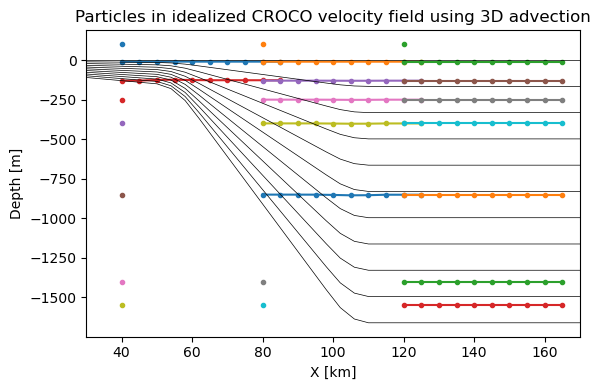

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ds = xr.open_zarr("/home1/datawork/kbalem/croco_particles3D.zarr")

ax.plot(ds.lon.T / 1e3, ds.z.T, ".-")

dsCROCO = xr.open_dataset("CROCO_idealized.nc")
for z in dsCROCO.s_w.values:
    ax.plot(fieldset.H.lon / 1e3, fieldset.H.data[0, 25, :] * z, "k", linewidth=0.5)
ax.set_xlabel("X [km]")
ax.set_xlim(30, 170)
ax.set_ylabel("Depth [m]")
ax.set_title("Particles in idealized CROCO velocity field using 3D advection")
plt.tight_layout()
plt.show()